# Wet/Dry classification

> This module groups the methods related to wet/dry classification of the CML signal.

In [ ]:
#| default_exp wetdry

In [ ]:
#| export
#| hide
import numpy as np
import xarray as xr

In [ ]:
#| hide
import matplotlib.pyplot as plt
from raincell import open_cml_sample, open_gauge_sample
from raincell.sample import get_cml_sample_fp
from raincell.data.merge import assign_nearest_gauge_to_link_center

In [ ]:
cml, gauges = open_cml_sample(), open_gauge_sample()

## Adaptation of the Schleiss and Berne (2010) algorithm to NMS min/max sampling

:::{.callout-caution}
This section contains an adaptation and a summary of the original paper. For a detailed explanation please check [Schleiss and Berne (2010)](caution)
:::

This method was originally designed to work on time-varying attenuation baseline. The main advantage is that it only uses path-integrated attenuation measurements from single-polarization and single frequency commercial microwave links and thus does not need any calibration from external sources such as rain gauges or radars, which makes it very suitable for territories with observation scarcity.

The method relies on the assumption that the variability of the signal is small during dry periods and large during rainy periods.

The method consists of two steps. First, the local variability $S_{W_t}$ is computed for a given moving time window. Second, a variability threshold $\sigma_0$ value is computed. Then:

$$\text{Decision rule: } \begin{cases} 
\text{rain if } S_{W_t} > \sigma_0 \\
\text{dry if } S_{W_t} \leq \sigma_0
\end{cases}$$

The original method was based on a 30-second sampling rate (instantaneous), from which $S_{W_t}$ was calculated for a temporal window of 15 to 35 minutes. This interval was found optimal for capturing rain dynamics. However, when working with NMS min/max sampling, the temporal windows are usually on the order of several minutes. Thus its not possible to calculate variability using the proposed formula. To tackle this issue, we use a simplified version of variability calculated as:

$$
S_{W_t} = TSL_{max} - RSL_{min}
$$

We've chosen this variable because we have found that for a **one variable model** this is the one that best predicts the wet/dry events.

In [ ]:
#| hide
isel = dict(cml_id=0, sublink_id=0) 
sublink = cml.isel(**isel)

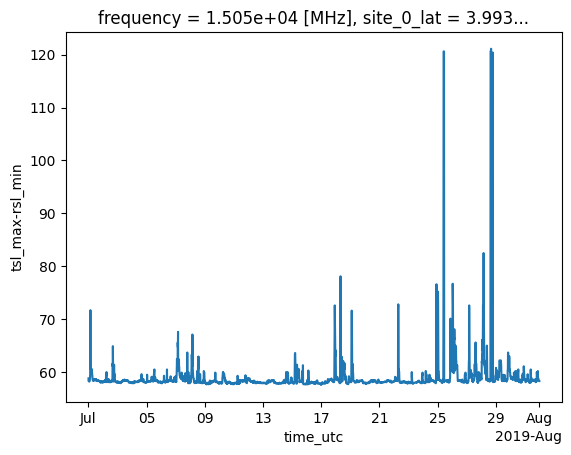

In [ ]:
#| hide
sw = sublink["tsl_max"] - sublink["rsl_min"]
sw.name = "tsl_max-rsl_min"
sw.plot();

Regarding the second step, two methods are proposed depending on the amount of available data. If few data are available, $\sigma_0$ can be estimated based on a collection of non-consecutive dry periods. However, this method requires local measurements to determine which are dry periods, so it is left for future work.

If a large amount of data is available (several months), we can assume that rainy periods represent only a fraction *r* of all the available periods. This fraction will depend on the region, so we recommend studying it for your specific use case. However, a default value of 0.05 to 0.15 (i.e., it rains 5% to 15% of the time) seems coherent with the original paper and our own experience. We will set it to 0.1. As a rule of thumb, a larger *r* will tend to produce more false positives while a smaller *r* will produce more false negatives. Thus, the threshold is computed as:
$$
\sigma_0 = q_{1−r}\{S_{W_t}\} 
$$
where $q_{1−r}$ denotes the $(1 − r)$ quantile.

In [ ]:
#| hide
r = 0.1
sigma0 = sw.quantile(q=(1-r), dim="time")
sigma0

<xarray.DataArray 'tsl_max-rsl_min' ()> Size: 8B
59.97
Coordinates: (1)

In [ ]:
#| hide
wet = sw >= sigma0
wet.drop_vars("quantile")

<xarray.DataArray 'tsl_max-rsl_min' (time: 2964)> Size: 3kB
False False False False False False ... False False False False False False
Coordinates: (10)

In [ ]:
#| hide
cml.quantile(0, dim="time")

/home/inigo/Documents/1_projects/raincell/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


<xarray.Dataset> Size: 63kB
Dimensions:      (cml_id: 126, sublink_id: 6)
Coordinates: (10)
Data variables:
    rsl_avg      (cml_id, sublink_id) float64 6kB -98.9 -87.7 nan ... nan nan
    tsl_avg      (cml_id, sublink_id) float64 6kB 10.0 10.0 nan ... nan nan nan
    rsl_min      (cml_id, sublink_id) float64 6kB -99.1 -95.9 nan ... nan nan
    tsl_min      (cml_id, sublink_id) float64 6kB 10.0 10.0 nan ... nan nan nan
    rsl_max      (cml_id, sublink_id) float64 6kB -98.6 -53.4 nan ... nan nan
    tsl_max      (cml_id, sublink_id) float64 6kB 10.0 10.0 nan ... nan nan nan

In [ ]:
#| hide
# remove runtime warning
all_nan_in_time = ~cml.isnull().all(dim="time")
cml.fillna(-9999).quantile(0, dim="time").where(all_nan_in_time)

<xarray.Dataset> Size: 63kB
Dimensions:      (cml_id: 126, sublink_id: 6)
Coordinates: (10)
Data variables:
    rsl_avg      (cml_id, sublink_id) float64 6kB -98.9 -87.7 nan ... nan nan
    tsl_avg      (cml_id, sublink_id) float64 6kB 10.0 10.0 nan ... nan nan nan
    rsl_min      (cml_id, sublink_id) float64 6kB -99.1 -95.9 nan ... nan nan
    tsl_min      (cml_id, sublink_id) float64 6kB 10.0 10.0 nan ... nan nan nan
    rsl_max      (cml_id, sublink_id) float64 6kB -98.6 -53.4 nan ... nan nan
    tsl_max      (cml_id, sublink_id) float64 6kB 10.0 10.0 nan ... nan nan nan

In [ ]:
#| export
def schleiss_n_berne_2010_nms_adapted(
        cml: xr.Dataset, # Input CML dataset with tsl_max and rsl_min variables
        r: float = 0.1 # Fraction of time it is assumed to be raining
        ) -> xr.Dataset:
    """ Wet Dry classification algorithm adapted to work with NMS sampling adapted from Schleiss and Berne (2010). """
    sw = cml["tsl_max"] - cml["rsl_min"]
    all_nan_in_time = ~sw.isnull().all(dim="time")
    sigma0 = sw.fillna(-9999).quantile(q=(1-r), dim="time").where(all_nan_in_time) # Rm runetime warning
    wet = sw >= sigma0
    wet = wet.drop_vars("quantile")
    wet.name = "wet"
    wet.attrs["long_name"] = "wet_dry_classification"
    wet.attrs["method"] = "schleiss_n_berne_2010_adapted_to_nms_min_max_sampling"
    return wet

In [ ]:
wet_pred = schleiss_n_berne_2010_nms_adapted(cml)
wet_pred

<xarray.DataArray 'wet' (cml_id: 126, sublink_id: 6, time: 2964)> Size: 2MB
False False False False False False ... False False False False False False
Coordinates: (10)
Attributes:
    long_name:  wet_dry_classification
    method:     schleiss_n_berne_2010_adapted_to_nms_min_max_sampling

In [ ]:
#| hide
wet_obs = (gauges[["tprate"]] > 0).rename({"tprate": "wet_obs"})

In [ ]:
#| hide
wet_link = assign_nearest_gauge_to_link_center(wet_pred.to_dataset().any(dim="sublink_id"), wet_obs)
wet_link

<xarray.Dataset> Size: 6MB
Dimensions:                  (cml_id: 126, time: 2976)
Coordinates: (12)
Data variables:
    wet                      (cml_id, time) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0
    wet_obs                  (cml_id, time) float64 3MB 0.0 0.0 0.0 ... nan nan

In [ ]:
#| hide
miss_link = (wet_link.wet - wet_link.wet_obs).dropna(dim="time")
miss_link

<xarray.DataArray (cml_id: 126, time: 2869)> Size: 3MB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0
Coordinates: (12)

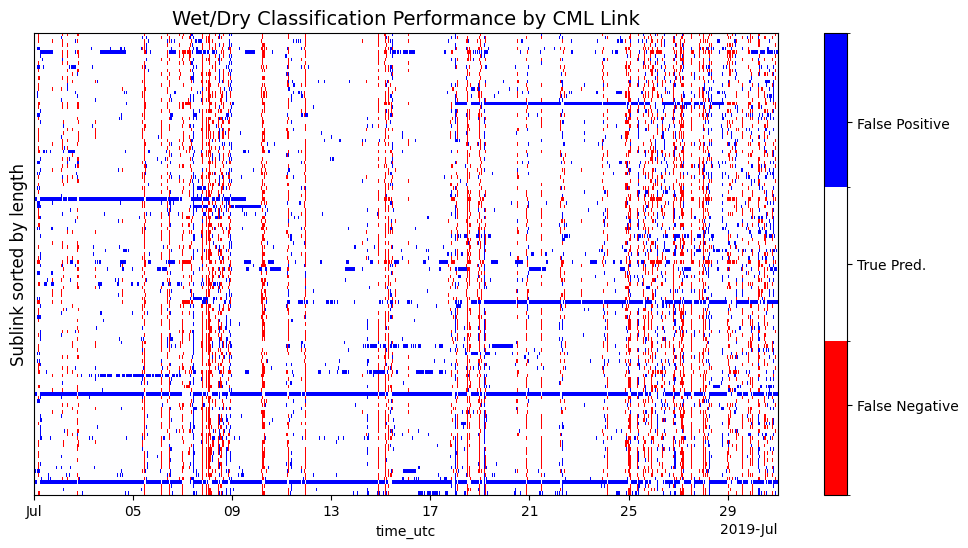

In [ ]:
#| echo:false
fig, ax = plt.subplots(figsize=(12, 6))
im = miss_link.sortby("length").plot.imshow(x="time", y="cml_id", cmap="bwr_r", robust=True, ax=ax, levels=[-1.1, -0.5, 0.5, 1.1])
ax.set_yticks([])
cbar = im.colorbar
cbar.set_ticks([-0.75, 0, 0.75])
cbar.set_ticklabels(['False Negative', 'True Pred.', 'False Positive'])
ax.set_title('Wet/Dry Classification Performance by CML Link', fontsize=14)
ax.set_ylabel('Sublink sorted by length', fontsize=12);

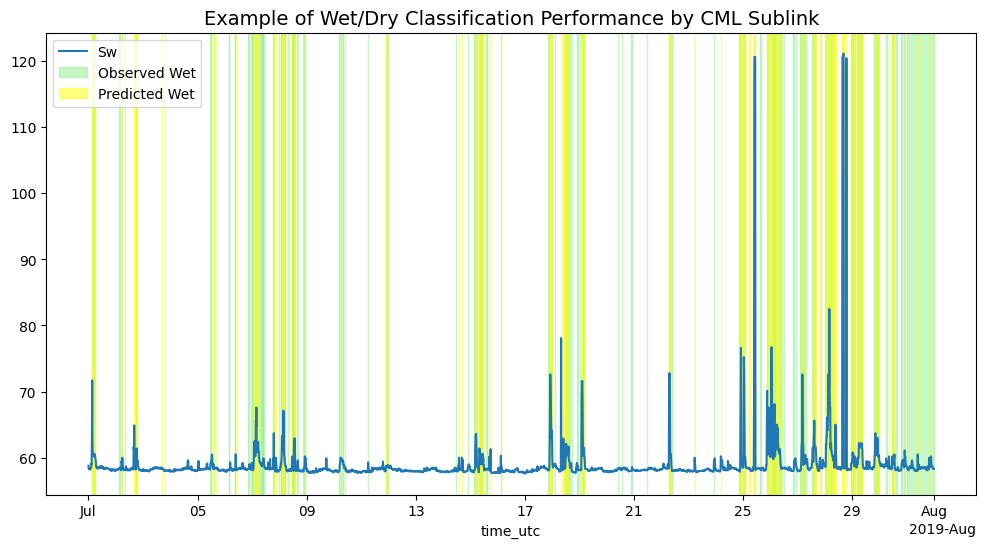

In [ ]:
#| echo:false
wet_sublinks = assign_nearest_gauge_to_link_center(wet_pred.to_dataset(), wet_obs)
ms = xr.merge([cml, wet_sublinks], join="outer") # multisensor dataset
sl = ms.isel(**isel)
fig, ax = plt.subplots(figsize=(12, 6))
(sl["tsl_max"] - sl["rsl_min"]).plot(ax=ax)
ax.fill_between(sl["time"], 0, 1, where=sl["wet_obs"], color='lightgreen', alpha=0.5, transform=ax.get_xaxis_transform())
ax.fill_between(sl["time"], 0, 1, where=sl["wet"], color='yellow', alpha=0.5, transform=ax.get_xaxis_transform())
ax.legend(['Sw', 'Observed Wet', 'Predicted Wet'], loc='upper left')
ax.set_title('Example of Wet/Dry Classification Performance by CML Sublink', fontsize=14);

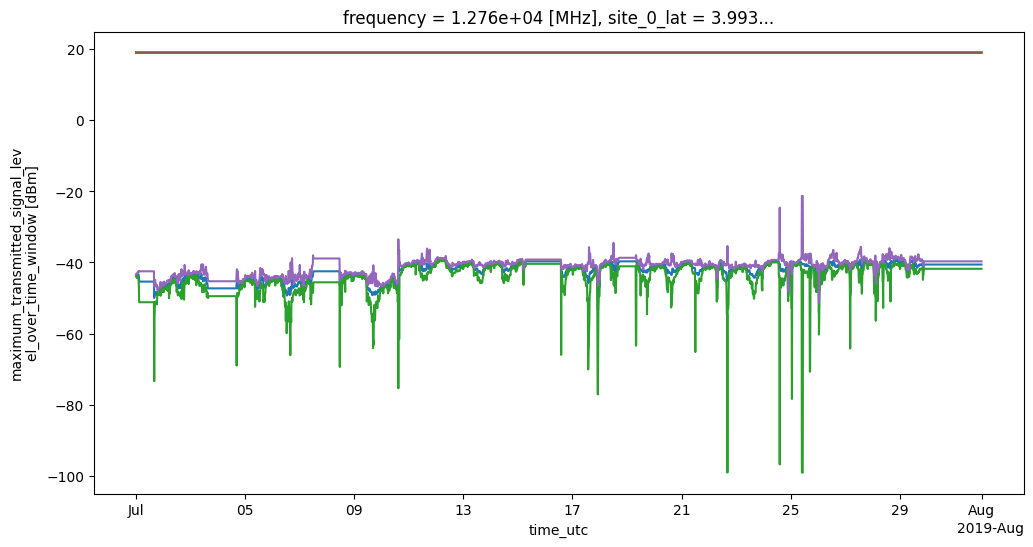

In [ ]:
#| hide
_ = cml.sel(cml_id=miss_link.cml_id[miss_link.mean("time") > 0.05]).isel(cml_id=0, sublink_id=0)
fig, ax = plt.subplots(figsize=(12, 6))
for v in _.data_vars:
    _[v].plot(ax=ax)

### References

- Schleiss, M., and A. Berne, 2010: Identification of dry and rainy periods using telecommunication microwave links. IEEE Geosci. Remote Sens. Lett., 7, 611–615, https://doi.org/10.1109/LGRS.2010.2043052.

### Sample data generation

As we will need sample data from different processing steps to help with development and illustration, we will save the generated wet classification as a sample.

In [ ]:
schleiss_n_berne_2010_nms_adapted(cml).to_netcdf(get_cml_sample_fp("wetdry"), encoding={"wet": {"zlib": True, "complevel": 5}})
